In [1]:
import sys
import os
sys.path.append(os.pardir)
# Embedding

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    '''
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        dW[self.idx] = dout
        return None
    '''
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        '''
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        '''
        
        np.add.at(dW, self.idx, dout)
        
        return None
    
    

In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        
        return dh

In [3]:
# 샘플링 방법 예제
import numpy as np

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))
print(np.random.choice(words, size=5))
print(np.random.choice(words, size=5, replace=False))

# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))


say
['say' 'goodbye' '.' '.' 'hello']
['goodbye' 'I' 'say' '.' 'you']
say


In [4]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)
print(np.sum(new_p))

[0.64196878 0.33150408 0.02652714]
1.0


In [5]:
import numpy as np
import sys
import os
sys.path.append(os.pardir)
from negative_sampling_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2
sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 0]
 [0 1]
 [3 2]]


In [6]:
import numpy as np
import sys
import os
sys.path.append(os.pardir)
from common.layers import Embedding, SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_sizee)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i]. forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        return dh

In [55]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

[[   0    1    2 ...    8    9   10]
 [   1    2    3 ...    9   10   11]
 [   2    3    4 ...   10   11   12]
 ...
 [ 706 9999  119 ...  258   64   39]
 [9999  119 1143 ...   64   39   26]
 [ 119 1143   69 ...   39   26   24]]
<class 'cupy.ndarray'>


C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


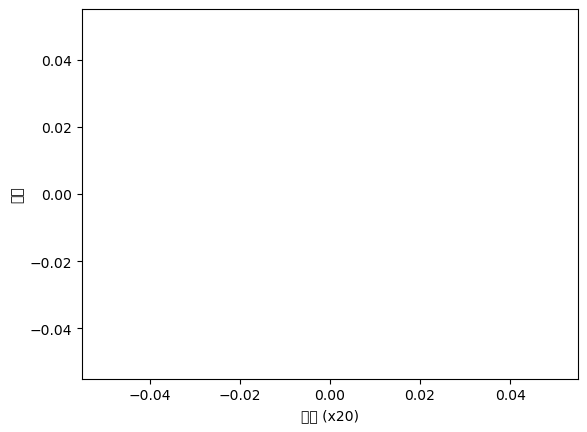

In [60]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 0

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
print(to_gpu(contexts))
print(type(to_gpu(contexts)))
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [62]:
# eval.py
# coding: utf-8
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slow